# Importing Required Libraries

In [746]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier


# Aspect Detection

### Data Loading and Data Analysis

In [747]:
data_aspect = pd.read_csv("aspect_labels.csv")
aspect_cols = ["price", "quality", "environment", "service", "other"]
X = data_aspect["sentence"]
Y = data_aspect[aspect_cols]

In [748]:
data_aspect.head()

,Unnamed: 0,sentence,price,quality,environment,service,other
0,0,i ordered egg soft noodles from here they didn t even included spoon or spork for the item how i have to eat noodles and also full of oily,0,1,0,1,0
1,1,ice cream was good but it s totally got melt as delivery boy took a lot of time to reach,0,1,0,1,0
2,2,he mentioned it as delivered as soon as he picked order,0,0,0,1,0
3,3,he took nearly 45 minutes to come,0,0,0,1,0
4,4,food was not good its from yesterday s food with less quanity i asked to customer care some one told they will refund and after 10 mins some one told not possible without giving proper food you people are charging and telling we are sorry if you will go for old chat also same issue i am facing maximum times this service is very bad services provding zomato i will put a complain to food inspection team they will definitly take a action zomato is full of fraud service it shuold stop some times delivery guys are eating customers food sometimes providing 2 days back food to customers,0,1,0,1,0


In [749]:
data_aspect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   5268 non-null   int64 
 1   sentence     5268 non-null   object
 2   price        5268 non-null   int64 
 3   quality      5268 non-null   int64 
 4   environment  5268 non-null   int64 
 5   service      5268 non-null   int64 
 6   other        5268 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 288.2+ KB


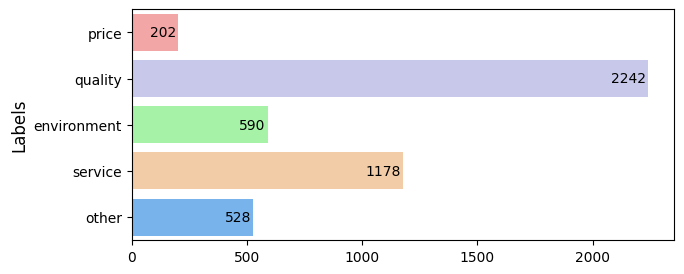

In [800]:
labels_counts = Y.sum(axis=0)
labels, counts = labels_counts.index, labels_counts.values

# Vẽ biểu đồ
plt.figure(figsize=(7, 3))
palette = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#C2C2F0'] 
ax = sns.barplot(x=counts, hue=counts, legend=False, y=labels, palette=palette, orient='h')

# Thêm giá trị lên thanh
for bar in ax.patches:
    y = bar.get_y() + bar.get_height() / 2
    label = bar.get_y()  # không cần, dùng trực tiếp bar
    width = bar.get_width()
    plt.text(width - 10, y, f'{int(width)}', va='center', ha='right', color='black')

# Tùy chỉnh trục và nhãn
ax.set_ylabel("Labels", fontsize=12)
plt.show()

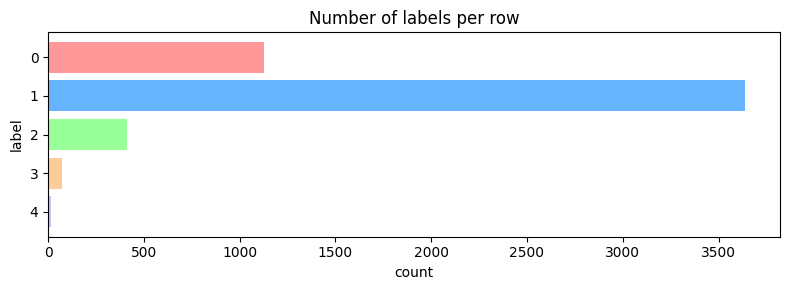

In [751]:
labels_counts = Y.sum(axis=1).value_counts().sort_index()
labels, counts = labels_counts.index, labels_counts.values

plt.figure(figsize=(8, 3))
plt.barh(labels, counts)
plt.xlabel("count")
plt.ylabel("label")
plt.title("Number of labels per row")
plt.barh(labels, counts, color=palette)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### Data splitting

In [752]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train_text.shape, X_test_text.shape, y_train.shape, y_test.shape

((4214,), (1054,), (4214, 5), (1054, 5))

### Preprocessing

In [753]:
keep_words = [
    # Phủ định (full + contracted)
    'not', 'no', 'none', 'never', 'nothing', 'nobody', 'nowhere', 'neither', 'without',
    'cannot', 'cant', 'couldnt', 'hasnt', 'nor'

    # Tính từ/trạng từ biểu cảm hoặc sắc thái rõ
    'well', 'interest',

    # Đại từ nhân xưng / chỉ định ngôi
    'i', 'you', 'me', 'my', 'your', 'we', 'us', 'our', 'myself', 'yourself', 'ourselves'
]


custom_stopwords = list(ENGLISH_STOP_WORDS.difference(keep_words))

In [754]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words=custom_stopwords)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

### Modeling

In [755]:
def train_and_evaluate(base_model, X_train, y_train, X_test, y_test):
    model = MultiOutputClassifier(base_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=Y.columns, zero_division=0))
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return recall, precision, f1

In [756]:
aspect_models = {
      "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
      "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
      "SVC": LinearSVC(max_iter=1000, random_state=42),
      "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0)
}

recall_dict_aspect = {}
precision_dict_aspect = {}
f1_dict_aspect = {}
for model_name, model in aspect_models.items():
    print(f'==== {model_name} ====')
    recall, precision, f1 = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    recall_dict_aspect[model_name] = recall
    precision_dict_aspect[model_name] = precision
    f1_dict_aspect[model_name] = f1

==== Logistic Regression ====
              precision    recall  f1-score   support

       price       0.58      0.64      0.61        39
     quality       0.81      0.72      0.76       465
 environment       0.61      0.74      0.67       112
     service       0.71      0.71      0.71       251
       other       0.43      0.70      0.54       107

   micro avg       0.68      0.72      0.70       974
   macro avg       0.63      0.70      0.66       974
weighted avg       0.71      0.72      0.71       974
 samples avg       0.56      0.58      0.56       974

==== Random Forest ====
              precision    recall  f1-score   support

       price       0.72      0.33      0.46        39
     quality       0.83      0.71      0.76       465
 environment       0.89      0.56      0.69       112
     service       0.83      0.59      0.69       251
       other       0.73      0.38      0.50       107

   micro avg       0.82      0.61      0.70       974
   macro avg       0.80

In [757]:
results_df = pd.DataFrame({
    'Recall': recall_dict_aspect,
    'Precision': precision_dict_aspect,
    'F1 Score': f1_dict_aspect
})

# Đưa model name thành cột thay vì index
results_df = results_df.reset_index().rename(columns={'index': 'Model'})

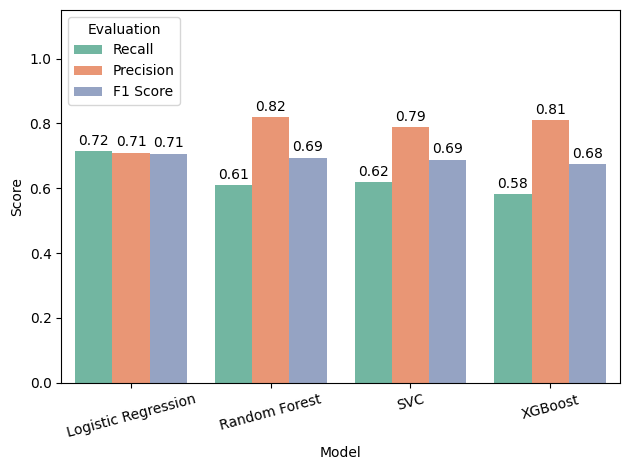

In [758]:
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

ax = sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='Set2')

plt.ylim(0, 1.15)

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    if height > 0.01:
        ax.annotate(f"{height:.2f}", 
                    (bar.get_x() + bar.get_width() / 2, height + 0.01),
                    ha='center', va='bottom', fontsize=10)


plt.xlabel("Model")
plt.legend(title="Evaluation")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Vì đây là bài toán xác định các khía cạnh có trong câu nên ta cần chú trọng vào tỉ lệ Recall hơn

Từ kết quả trên ta thấy mô hình Logistic Regression cho kết quả tốt nhất nên ta lựa chọn mô hình này cho phần Aspect detection

# Sentiment Classification

### Data Loading and Data Analysis

In [759]:
df = pd.read_csv('aspect_sentiment.csv')
df.shape, df.columns

((4740, 4),
 Index(['Unnamed: 0', 'sentence', 'aspect', 'sentiment'], dtype='object'))

In [760]:
df['sentiment'].value_counts()

sentiment
Negative    2441
Positive    2016
Neutral      283
Name: count, dtype: int64

<Axes: ylabel='count'>

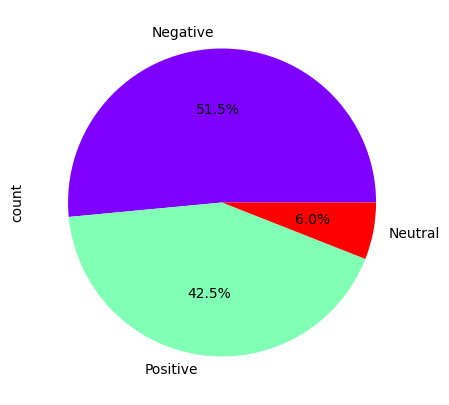

In [761]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5, 5), colormap='rainbow')

In [762]:
df['sentiment'] = df['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})

In [763]:
df['pair'] = df['sentence'] + ' [ASP] ' + df['aspect']
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', None) 
df.head()

,Unnamed: 0,sentence,aspect,sentiment,pair
0,0,i ordered egg soft noodles from here they didn t even included spoon or spork for the item how i have to eat noodles and also full of oily,quality,0,i ordered egg soft noodles from here they didn t even included spoon or spork for the item how i have to eat noodles and also full of oily [ASP] quality
1,1,i ordered egg soft noodles from here they didn t even included spoon or spork for the item how i have to eat noodles and also full of oily,service,0,i ordered egg soft noodles from here they didn t even included spoon or spork for the item how i have to eat noodles and also full of oily [ASP] service
2,2,ice cream was good but it s totally got melt as delivery boy took a lot of time to reach,quality,1,ice cream was good but it s totally got melt as delivery boy took a lot of time to reach [ASP] quality
3,3,ice cream was good but it s totally got melt as delivery boy took a lot of time to reach,service,0,ice cream was good but it s totally got melt as delivery boy took a lot of time to reach [ASP] service
4,4,he mentioned it as delivered as soon as he picked order,service,0,he mentioned it as delivered as soon as he picked order [ASP] service


In [764]:
df.drop(columns=['sentence', 'aspect'], inplace=True)

### Data splitting

In [765]:
X_train, X_test, y_train, y_test = train_test_split(df['pair'], df['sentiment'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3792,), (948,), (3792,), (948,))

### Preprocessing

In [766]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words=custom_stopwords)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### Modeling

In [767]:
def evaluate_model(y_test, y_pred):
    labels = [1, 0, 2]  # Positive, Negative, Neutral
    print(classification_report(y_test, y_pred, labels=labels))
    
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    print("Confusion Matrix:")
    print(f"True\\Pred:  Positive   Negative   Neutral")
    print(f"Positive     {cm[0][0]:>5}      {cm[0][1]:>5}      {cm[0][2]:>5}")
    print(f"Negative     {cm[1][0]:>5}      {cm[1][1]:>5}      {cm[1][2]:>5}")
    print(f"Neutral      {cm[2][0]:>5}      {cm[2][1]:>5}      {cm[2][2]:>5}\n")

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred)

    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return recall, precision, f1


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Linear SVC': LinearSVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42)
}

In [770]:
recall_dict_sentiment = {}
precision_dict_sentiment = {}
f1_dict_sentiment = {}
for model_name, model in aspect_models.items():
    print(f'==== {model_name} ====')
    recall, precision, f1 = train_and_evaluate(model, X_train_vec, y_train, X_test_vec, y_test)
    recall_dict_sentiment[model_name] = recall
    precision_dict_sentiment[model_name] = precision
    f1_dict_sentiment[model_name] = f1

==== Logistic Regression ====
              precision    recall  f1-score   support

           1       0.83      0.78      0.80       412
           0       0.84      0.83      0.84       486
           2       0.23      0.36      0.28        50

    accuracy                           0.78       948
   macro avg       0.63      0.66      0.64       948
weighted avg       0.80      0.78      0.79       948

Confusion Matrix:
True\Pred:  Positive   Negative   Neutral
Positive       321         62         29
Negative        48        405         33
Neutral         18         14         18

==== Random Forest ====
              precision    recall  f1-score   support

           1       0.82      0.74      0.78       412
           0       0.78      0.90      0.83       486
           2       0.33      0.12      0.18        50

    accuracy                           0.79       948
   macro avg       0.64      0.58      0.60       948
weighted avg       0.77      0.79      0.77       948



In [771]:
results_df = pd.DataFrame({
    'Recall': recall_dict_sentiment,
    'Precision': precision_dict_sentiment,
    'F1 Score': f1_dict_sentiment
})

# Đưa model name thành cột thay vì index
results_df = results_df.reset_index().rename(columns={'index': 'Model'})

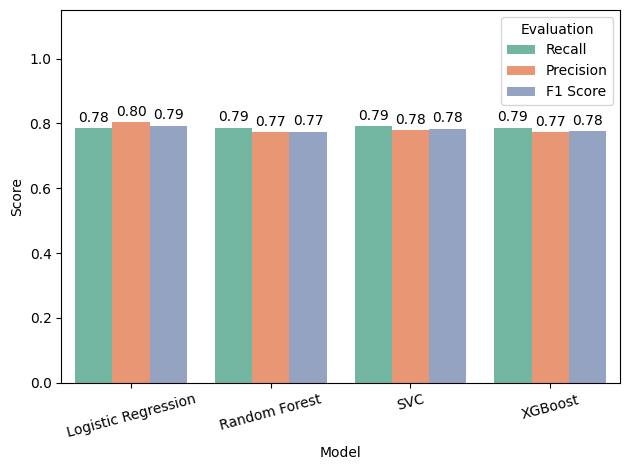

In [772]:
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

ax = sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='Set2')

plt.ylim(0, 1.15)

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    if height > 0.01:
        ax.annotate(f"{height:.2f}", 
                    (bar.get_x() + bar.get_width() / 2, height + 0.01),
                    ha='center', va='bottom', fontsize=10)


plt.xlabel("Model")
plt.legend(title="Evaluation")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Ở phần này, ta cần chú trọng kết quả Precision để tránh việc dự đoán sai nhãn

Từ kết quả trên ta thấy mô hình Logistic Regression cho kết quả tốt nhất nên ta lựa chọn mô hình này cho phần Sentiment Classification

# Predict

### Test data

In [774]:
test = pd.read_csv(r'D:\Đại học\DS T5\Model\test_restaurants.csv')
test.drop(columns=['Name', 'Rating'])
test

,restaurant_id,restaurant_name,Name,Rating,Comment
0,1,Anar Indian Restaurant,Gep Yalong,5,"Everything was amazing. Food and variety with customizability, ambiance with music, the service, and even the comfort room was excellent.\n\nWe got the Beef Biryani and Lamb Masala with plain naan. Serving was generous, enough for 3. No gamey or domesticated taste! Was also easy to chew / eat. Really delicious and filling, rich taste.\n\nAlso had Mango Lassi. It was really heavy and delicious!\n\nService was good and fast. Comfort room was clean and complete with supplies (no bidet).\n\nI would recommend this place to everyone."
1,1,Anar Indian Restaurant,Mario Garcia-Gillespie,5,Fantastic local restaurant with a great dinner for 2 deal that will definitely leave food for lunch the next day. Food was cook to perfection and the curry and spices were spot on.
2,1,Anar Indian Restaurant,Sukanya Arunkumar,5,We had come on a visit to LA. We had ordered takeouts of veg biryani and samosa on the first day of our visit. They were delicious! They told us that they even deliver. So next time we ordered butter naan and dhal tadka over the phone and they delivered within 30-40 minutes to the hotel we stayed in. It was so tasty! This restaurant is way too underrated. I don't understand why Anar Indian Restaurant never showed up when we were searching for Indian restaurants on the internet nearby the hotel we stayed. We are so glad we found it by accident while we walked across to get some stuff from CVS. Highly recommend this place!
3,1,Anar Indian Restaurant,Katherine,5,"This is my favorite Indian spot in LA, and the quality of the food keeps me coming back. Every dish I’ve tried has been deeply flavorful, balanced, and clearly made with fresh ingredients. The lunch specials are a perfect way to sample a variety, served with aromatic white rice and soft, warm naan. The masala is rich with layered spice, the sag is consistently earthy and comforting, and the korma has a silky, complex flavor that stands out. The paratha is flaky and satisfying, and the naan is always pillowy and charred just right. I’m working my way through the menu and haven’t hit a single miss."
4,1,Anar Indian Restaurant,Priyanka Bengaluru,4,"Service was amazing. Tried their one person dinner - it was amazing. Dal soup could have been better, chicken tandoor was yum, naan and chicken vindaloo was yum, samosa was good too. Quantity was perfect. Would return back to try other items on their menu."
...,...,...,...,...,...
200,2,Gate Of India,Saud Yeahhea Al Rahul,5,Definitely recommend these guys best in town
201,2,Gate Of India,Not Normal Limited,5,Very good. Can’t wait to come back.
202,2,Gate Of India,Alex Antonian,5,Amazing and delicious vegan food!!!
203,2,Gate Of India,Ashish Chandoskar,5,Amazing food and amazing ambiance


### Preprocessing

In [775]:
import nltk
from nltk.tokenize import sent_tokenize
test['id'] = test.index + 1

test['sentence'] = test['Comment'].apply(nltk.sent_tokenize)
test_sentences = test.explode('sentence')[['id', 'restaurant_id', 'restaurant_name', 'sentence',]].reset_index(drop=True)

test_sentences['id_sentence'] = test_sentences.index + 1
test_sentences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               637 non-null    int64 
 1   restaurant_id    637 non-null    int64 
 2   restaurant_name  637 non-null    object
 3   sentence         637 non-null    object
 4   id_sentence      637 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 25.0+ KB


In [776]:
test_sentences

,id,restaurant_id,restaurant_name,sentence,id_sentence
0,1,1,Anar Indian Restaurant,Everything was amazing.,1
1,1,1,Anar Indian Restaurant,"Food and variety with customizability, ambiance with music, the service, and even the comfort room was excellent.",2
2,1,1,Anar Indian Restaurant,We got the Beef Biryani and Lamb Masala with plain naan.,3
3,1,1,Anar Indian Restaurant,"Serving was generous, enough for 3.",4
4,1,1,Anar Indian Restaurant,No gamey or domesticated taste!,5
...,...,...,...,...,...
632,202,2,Gate Of India,Can’t wait to come back.,633
633,203,2,Gate Of India,Amazing and delicious vegan food!!,634
634,203,2,Gate Of India,!,635
635,204,2,Gate Of India,Amazing food and amazing ambiance,636


In [777]:
import re

def clean_text(txt):
    if not isinstance(txt,str):
        txt = str(txt)
    txt = txt.lower()
    txt = re.sub(r'\\[nt]*',' ',txt) #removes \n and \t tags
    txt = re.sub(r'[^A-Za-z0-9\s]',' ',txt) #removes non textual data
    if isinstance(txt, str):
        return re.sub(r'\s+', ' ', txt).strip()
    return txt

In [778]:
test_sentences['sentence'] = test_sentences['sentence'].apply(clean_text)

In [779]:
test_sentences = test_sentences[~(test_sentences['sentence'] == '')]

In [780]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words=custom_stopwords)
X_train = vectorizer.fit_transform(X)
X_test = vectorizer.transform(test_sentences['sentence'])

Y_train = Y

### Aspect detection

In [781]:
clf_model = LogisticRegression(max_iter=1000, class_weight='balanced')
multi_xgb_aspect = MultiOutputClassifier(clf_model)
multi_xgb_aspect.fit(X_train, Y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000))

In [782]:
y_pred = multi_xgb_aspect.predict(X_test)
y_pred[:10]

array([[0, 1, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]], dtype=int64)

In [783]:
y_pred = pd.DataFrame(y_pred, columns=aspect_cols)
y_pred.head()

,price,quality,environment,service,other
0,0,1,1,0,0
1,0,1,1,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,1,0,0,0


### Sentiment classification

In [784]:
test_sentiment = pd.concat([test_sentences.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)

In [785]:
result = []

for _, row in test_sentiment.iterrows():
   sentence = row['sentence']
   id = row['id']
   id_sentence = row['id_sentence']
   id_restaurant = row['restaurant_id']
   restaurant = row['restaurant_name']
   for aspect in aspect_cols:
      sentiment = row[aspect]
      if sentiment:
            result.append({
               'id_restaurants': id_restaurant,
               'restaurant': restaurant,
               'id': id,
               'id_sentence': id_sentence,
               'sentence': sentence,
               'aspect': aspect,
            })
result = pd.DataFrame(result)
result['pair'] = result['sentence'] + ' [ASP] ' + result['aspect']

In [786]:
result.head()

,id_restaurants,restaurant,id,id_sentence,sentence,aspect,pair
0,1,Anar Indian Restaurant,1,1,everything was amazing,quality,everything was amazing [ASP] quality
1,1,Anar Indian Restaurant,1,1,everything was amazing,environment,everything was amazing [ASP] environment
2,1,Anar Indian Restaurant,1,2,food and variety with customizability ambiance with music the service and even the comfort room was excellent,quality,food and variety with customizability ambiance with music the service and even the comfort room was excellent [ASP] quality
3,1,Anar Indian Restaurant,1,2,food and variety with customizability ambiance with music the service and even the comfort room was excellent,environment,food and variety with customizability ambiance with music the service and even the comfort room was excellent [ASP] environment
4,1,Anar Indian Restaurant,1,2,food and variety with customizability ambiance with music the service and even the comfort room was excellent,service,food and variety with customizability ambiance with music the service and even the comfort room was excellent [ASP] service


In [787]:
X_train_vec = vectorizer.fit_transform(df['pair'])
X_test_vec = vectorizer.transform(result['pair'])

Y_train = df['sentiment']

In [788]:
clf_model_sentiment = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_model_sentiment.fit(X_train_vec, Y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [789]:
y_pred = clf_model_sentiment.predict(X_test_vec)
y_pred = pd.DataFrame(y_pred, columns=['sentiment'])
y_pred['sentiment'] = y_pred['sentiment'].map({1: int(1), 0: int(-1), 2: int(0)})

In [790]:
result_sentiment = pd.concat([result[['restaurant', 'id_sentence', 'sentence', 'aspect']], y_pred], axis=1)
result_sentiment.head()

,restaurant,id_sentence,sentence,aspect,sentiment
0,Anar Indian Restaurant,1,everything was amazing,quality,1
1,Anar Indian Restaurant,1,everything was amazing,environment,1
2,Anar Indian Restaurant,2,food and variety with customizability ambiance with music the service and even the comfort room was excellent,quality,1
3,Anar Indian Restaurant,2,food and variety with customizability ambiance with music the service and even the comfort room was excellent,environment,1
4,Anar Indian Restaurant,2,food and variety with customizability ambiance with music the service and even the comfort room was excellent,service,1


### Output

In [791]:
Anar = result_sentiment[result_sentiment['restaurant'] == 'Anar Indian Restaurant']
Gate = result_sentiment[result_sentiment['restaurant'] == 'Gate Of India']

In [792]:
def visualiztion(df, name):
    sentiment_counts = df.groupby(['aspect', 'sentiment']).size().reset_index(name='count')

    pivot_df = sentiment_counts.pivot(index='aspect', columns='sentiment', values='count').fillna(0).astype(int)

    sentiments = [-1, 0, 1]
    colors = ['#FF9999', '#CCCCCC', '#99FF99']  # màu cho từng sentiment
    labels = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']

    pivot_df = pivot_df[sentiments]
    pivot_df.plot(kind='bar', figsize=(7, 3), color=colors)

    # Chú thích
    plt.title(name)
    plt.xlabel("Aspect")
    plt.ylabel("Count")
    plt.legend(labels, title="Sentiment")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

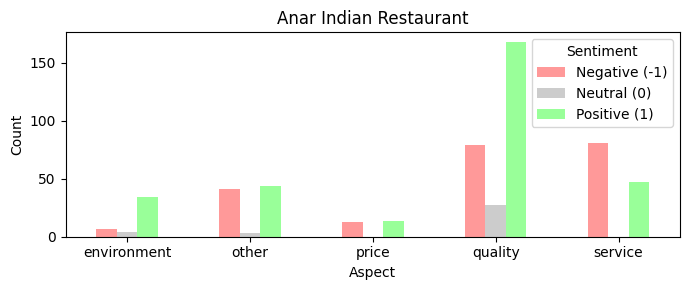

In [793]:
visualiztion(Anar, 'Anar Indian Restaurant')

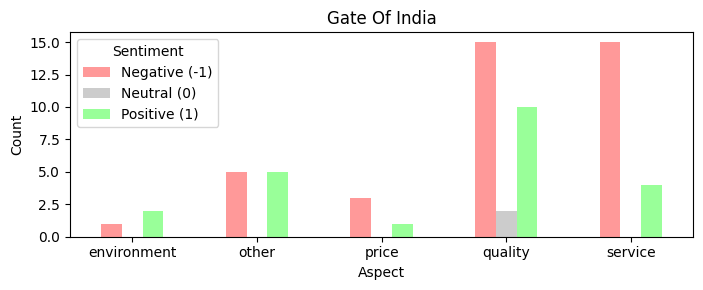

In [794]:
visualiztion(Gate, 'Gate Of India')

In [795]:
def output(df):
   sentiment_counts = df.groupby(['aspect', 'sentiment']).size().reset_index(name='count')
   pivot_df = sentiment_counts.pivot(index='aspect', columns='sentiment', values='count').fillna(0).astype(int)

   pivot_df.columns.name = None
   # Calculate ratio between -1 and 1 for each aspect
   pivot_df['ratio'] = pivot_df[1] / pivot_df[-1].replace(0, 1e-6)

   # Assign label based on ratio
   def label_ratio(r):
      if r < 1:
         return 'Negative'
      elif r < 1.5:
         return 'Neutral'
      else:
         return 'Positive'
   pivot_df['label'] = pivot_df['ratio'].apply(label_ratio)
   result_df = pivot_df.reset_index()

   if aspect_cols is not None:
        result_df['aspect'] = pd.Categorical(result_df['aspect'], categories=aspect_cols, ordered=True)
        result_df = result_df.sort_values('aspect')
   return result_df[['aspect', 'label']].reset_index(drop=True)

In [796]:
Anar_aspect = output(Anar)
Anar_aspect

,aspect,label
0,price,Neutral
1,quality,Positive
2,environment,Positive
3,service,Negative
4,other,Neutral


In [797]:
Gate_aspect = output(Gate)
Gate_aspect

,aspect,label
0,price,Negative
1,quality,Negative
2,environment,Positive
3,service,Negative
4,other,Neutral
